In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data loading to data dir

In [5]:
import random
import shutil

import os
import zipfile
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [6]:
PATH = 'drive/MyDrive'

In [7]:
# for zip_file in os.listdir(path=f"{PATH}/raw_data"):
#     with zipfile.ZipFile(f"{PATH}/raw_data/{zip_file}", 'r') as zip_ref:
#         zip_ref.extractall(f'{PATH}/raw_data')
#         print(f"Extracted: {zip_file}")

In [ ]:
# for file in os.listdir(path=f"{PATH}/raw_data"):
#     if file.endswith(".zip"):
#         file_path = os.path.join(f"{PATH}/raw_data", file)
#         os.remove(file_path)

## EDA and Data split

In [ ]:
#shutil.rmtree(f"{PATH}/data")

Кількість класів: **4**

['angry', 'happy', 'relaxed', 'sad']

In [ ]:
train_ratio, val_ratio = 0.6, 0.2

os.makedirs(f"{PATH}/data/train", exist_ok=True)
os.makedirs(f"{PATH}/data/val", exist_ok=True)
os.makedirs(f"{PATH}/data/test", exist_ok=True)

folders = os.listdir(f"{PATH}/raw_data")

for folder in folders:
    folder_path = os.path.join(f"{PATH}/raw_data", folder)
    if not os.path.isdir(folder_path):
        continue

    files = os.listdir(folder_path)
    random.shuffle(files)

    train_end = int(len(files) * train_ratio)
    val_end = train_end + int(len(files) * val_ratio)

    subsets = {"train": files[:train_end], "val": files[train_end:val_end], "test": files[val_end:]}

    for subset, subset_files in subsets.items():
        subset_folder = os.path.join(f"{PATH}/data", subset, folder)
        os.makedirs(subset_folder, exist_ok=True)

        for file in subset_files:
            shutil.move(os.path.join(folder_path, file), os.path.join(subset_folder, file))

Метод який виводить структуру папок, кількість фото в кожній директорії, розмір картинок та формат файлів

In [8]:
from PIL import Image

all_files = []

def print_tree(start_path):
    for root, dirs, files in os.walk(start_path):
        level = root.replace(start_path, "").count(os.sep)
        indent = "│   " * level + "├── "
        print(f"{indent}{os.path.basename(root)}: ({len(files)} files inside)")

        parent_dir = os.path.basename(root)

        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    all_files.append({
                        'file': file,
                        'parent_dir': parent_dir,
                        'width': img.width,
                        'height': img.height,
                        'file_format': img.format
                    })
            except Exception as e:
                pass

print_tree(f'{PATH}/data')

├── data: (0 files inside)
│   ├── train: (0 files inside)
│   │   ├── sad: (2642 files inside)
│   │   ├── angry: (1353 files inside)
│   │   ├── happy: (2876 files inside)
│   │   ├── relaxed: (2583 files inside)
│   ├── val: (0 files inside)
│   │   ├── sad: (880 files inside)
│   │   ├── angry: (451 files inside)
│   │   ├── happy: (958 files inside)
│   │   ├── relaxed: (861 files inside)
│   ├── test: (0 files inside)
│   │   ├── sad: (882 files inside)
│   │   ├── angry: (452 files inside)
│   │   ├── happy: (960 files inside)
│   │   ├── relaxed: (861 files inside)


In [14]:
import pandas as pd

files_df = pd.DataFrame(all_files)

print(
    f"""
    Photo size: {files_df['width'].min()} x {files_df['height'].min()}
    File format: {files_df['file_format'].unique()}
    """
)


    Photo size: 384 x 384
    File format: ['JPEG']
    


In [15]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

not_train_ransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [16]:
batch_size = 32

train_dataset = datasets.ImageFolder(root=f"{PATH}/data/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f"{PATH}/data/val", transform=not_train_ransforms)
test_dataset = datasets.ImageFolder(root=f"{PATH}/data/test", transform=not_train_ransforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

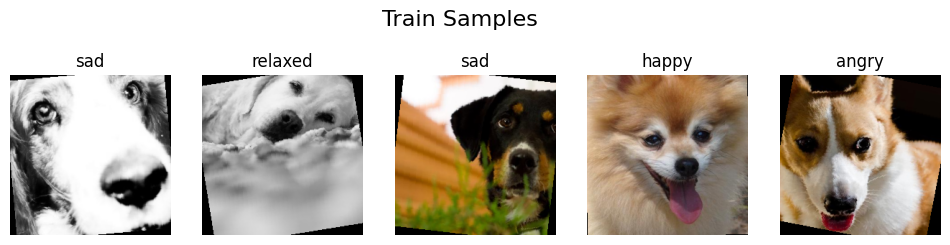

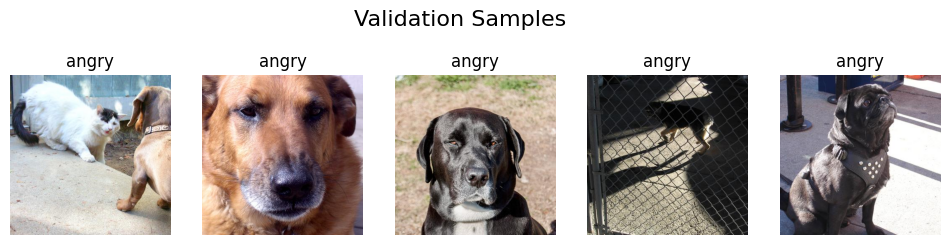

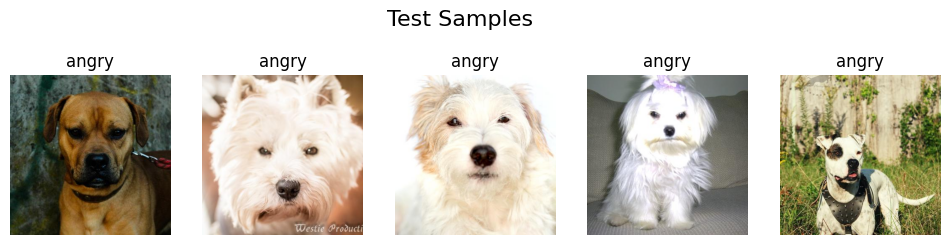

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

def visualize_loader(loader, dataset_name, class_names):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 3))

    for i in range(5):
        plt.subplot(1, 5, i + 1)
        imshow(images[i], class_names[labels[i]])

    plt.suptitle(f"{dataset_name} Samples", fontsize=16)
    plt.show()

class_names = train_dataset.classes

visualize_loader(train_loader, "Train", class_names)
visualize_loader(val_loader, "Validation", class_names)
visualize_loader(test_loader, "Test", class_names)

<ipython-input-13-e9340c5111f1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=file_counts, x="parent_dir", y="file_count", palette="viridis")


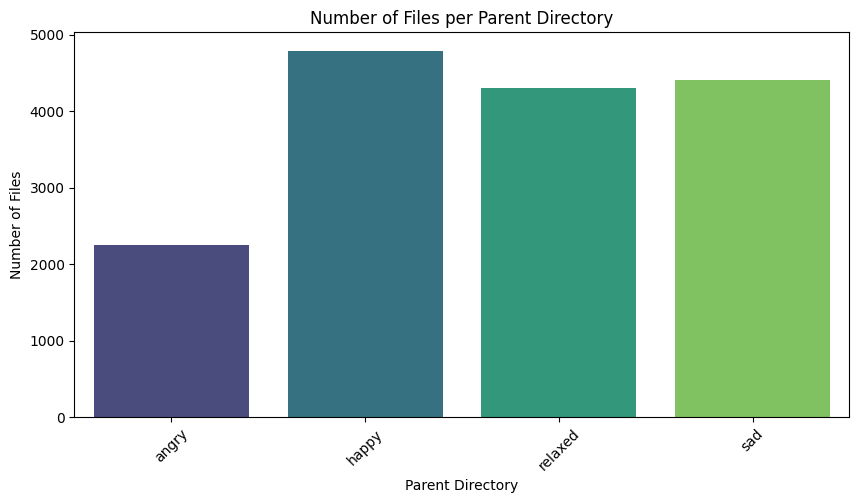

In [13]:
import seaborn as sns

file_counts = files_df.groupby("parent_dir").size().reset_index(name="file_count")

plt.figure(figsize=(10, 5))
sns.barplot(data=file_counts, x="parent_dir", y="file_count", palette="viridis")

plt.xlabel("Parent Directory")
plt.ylabel("Number of Files")
plt.title("Number of Files per Parent Directory")
plt.xticks(rotation=45)
plt.show()